In [1]:
import sys
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy import interpolate 
sys.path.append(r'C:\Chuji\Code_and_Data\MyCode')

import Circuit_Simulator 
import PulseGenerator as PG
from toolfunc import *
from toolfunc.adia_analysis import *
from toolfunc.pulse_filter import *
import scipy.optimize as sci_op
from toolfunc import DE

{'Q1_freq': '6000.0MHz', 'Q1_anhar': '-125.0MHz', 'Q2_freq': '8500.0MHz', 'Q2_anhar': '-150.0MHz', 'Q3_freq': '5400.0MHz', 'Q3_anhar': '-125.0MHz', 'g12': '128.5457MHz', 'g13': '8.5381MHz', 'g23': '121.9492MHz'}


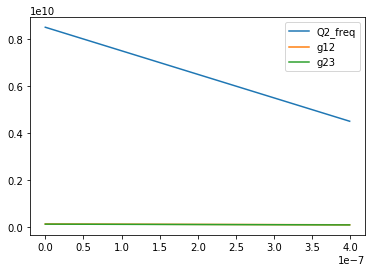

In [2]:
raw_config = Circuit_Simulator.RawConfig(qubit_num=3,dimension=3,circuit_type=1,initial_state='ground',sampling_rate=1e9)
raw_config.load_default_value(modulation=True,decoherence=False,use_capacitance=False)

flux_pulse = np.linspace(0/7.5,4/7.5,400)
freq_array = 8.5e9-flux_pulse * (8.5e9 - 1e9)

raw_config.setValue('Q1 f01_max',6.0e9)
raw_config.setValue('Q2 f01_max',8.5e9)
raw_config.setValue('Q3 f01_max',5.4e9)
raw_config.setValue('Q1 f01_min',1e9)
raw_config.setValue('Q2 f01_min',1e9)
raw_config.setValue('Q3 f01_min',1e9)
raw_config.setValue('Q1 Ec',0.25e9)
raw_config.setValue('Q2 Ec',0.30e9)
raw_config.setValue('Q3 Ec',0.25e9)

raw_config.setValue('r12',0.018)
raw_config.setValue('r23',0.018)
raw_config.setValue('r13',0.0015)

raw_config.setValue('Q2 Voltage period',-1)
raw_config.setValue('Q2 Voltage operating point',0.00)
raw_config.setValue('Q2 Flux',flux_pulse)

simu_config = Circuit_Simulator.read_config(raw_config.get_dict())
Simulator = Circuit_Simulator.Simulator(simu_config)
Simulator.show_pulse()

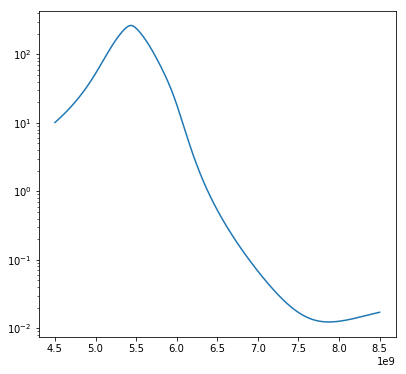

In [3]:
Simulator.performsimulation(solver_type=2,resample_factor=1,eigen_cloest_to_bare=False ,sort_by_maximum_overlap=True,gap=12e6)

fig = plt.figure(figsize=[6.4,6])
ax = fig.add_subplot(111)

eigen_trace = Simulator.EigenResult.get_Ener_gap_trace('101-100-001+000')
ax.plot(freq_array[0:400],-eigen_trace[0:400]/1e6)

ax.set_yscale('log')

In [4]:
%matplotlib qt

In [43]:
%matplotlib inline

In [60]:
def cost_func_deviation(pulse_params,*args):
    gate_time,SRATE,d_w1,d_w2,d_wc,d_alpha1,d_alpha2,d_alphac,d_r1c,d_r2c,d_r12=args
    lamb1 = pulse_params
    total_len = gate_time + 8e-9 
    
    Seq=PG.Sequence(total_len=total_len,sample_rate=SRATE,complex_trace=False)
    Seq.clear_pulse(tips_on=False)
    Seq.add_pulse('Adiabatic',t0=gate_time/2+8e-9/2,width=gate_time,plateau=0e-9,frequency=0,F_Terms=1,Lcoeff=np.array(lamb1),Q1_freq=6.0e9+d_w1,
                 CPLR_idle_freq=7.87e9+d_wc,Q2_freq=5.4e9+d_w2,constant_coupling=False,r1c=0.018*(1+d_r1c),r2c=0.018*(1+d_r2c),r12=0.0015*(1+d_r12),anhar_CPLR=-300e6+d_alphac,
                 anhar_Q1=-250e6+d_alpha1,anhar_Q2=-250e6+d_alpha2,negative_amplitude=False,dfdV=7.87e9-1e9,gap_threshold=8e6,freqpoints=301,pulsepoints=601)
    Seq.add_filter('Gauss Low Pass',300e6)
    flux_pulse=Seq.get_sequence()

    raw_config = Circuit_Simulator.RawConfig(qubit_num=3,dimension=3,circuit_type=1,initial_state='-Z+Z+Z',sampling_rate=SRATE)
    raw_config.load_default_value(modulation=True,decoherence=False,use_capacitance=False)
    raw_config.setValue('Q1 f01_max',6.0e9)
    raw_config.setValue('Q2 f01_max',7.87e9)
    raw_config.setValue('Q3 f01_max',5.4e9)
    raw_config.setValue('Q1 f01_min',1e9)
    raw_config.setValue('Q2 f01_min',1e9)
    raw_config.setValue('Q3 f01_min',1e9)
    raw_config.setValue('Q1 Ec',0.25e9)
    raw_config.setValue('Q2 Ec',0.3e9)
    raw_config.setValue('Q3 Ec',0.25e9)
    raw_config.setValue('r12',0.018)
    raw_config.setValue('r23',0.018)
    raw_config.setValue('r13',0.0015)
    raw_config.setValue('Q2 Voltage period',-1)
    raw_config.setValue('Q2 Voltage operating point',0)
    raw_config.setValue('Q2 Flux',flux_pulse)
    simu_config = Circuit_Simulator.read_config(raw_config.get_dict())
    Simulator = Circuit_Simulator.Simulator(simu_config)
    Simulator.performsimulation(solver_type=1)
    Simulator.UnitaryResult.get_U(-1)
    Simulator.UnitaryResult.get_subspace_operator(['000','001','100','101'])
    Simulator.UnitaryResult.set_Target_gate('CZ')
    Simulator.UnitaryResult.remove_single_qubit_gate()
    
    Simulator.UnitaryResult.get_Gate_Fidelity()
    fidelity = Simulator.UnitaryResult.Gate_Fidelity
#     print('coeff',pulse_params)
#     print('error',1-fidelity)
    return 1 - fidelity

In [61]:
[d_w1,d_w2,d_wc,d_alpha1,d_alpha2,d_alphac,d_r1c,d_r2c,d_r12]=np.zeros(9)

In [ ]:
gate_time=30e-9
SRATE=10e9
raw_initial_seeds=[0.8]

[d_w1,d_w2,d_wc,d_alpha1,d_alpha2,d_alphac,d_r1c,d_r2c,d_r12]=np.zeros(9)

error_dw1=[]
param_dw1=[]
for d_wc in np.arange(-100e6,100.1e6,20e6):
    DATA = sci_op.minimize(cost_func_deviation,raw_initial_seeds,args=(gate_time,SRATE,d_w1,d_w2,d_wc,d_alpha1,d_alpha2,d_alphac,d_r1c,d_r2c,d_r12), method='Nelder-Mead', options={'disp': True,'ftol':1e-4,'xtol':1e-4,'maxiter':30})
    error_dw1.append(DATA.fun)
    param_dw1.append(DATA.x)
    raw_initial_seeds=DATA.x

In [ ]:
# fig = plt.figure()
# ax=fig.add_subplot(111)
# ax.plot( np.arange(-100e6,100.1e6,20e6) ,error_dw1 )
# ax.set_yscale('log')

# param_dw1

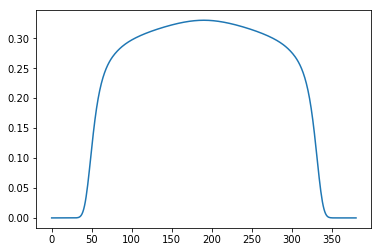

In [53]:
gate_time=30e-9
SRATE=10e9
[d_w1,d_w2,d_wc,d_alpha1,d_alpha2,d_alphac,d_r1c,d_r2c,d_r12]=np.zeros(9)
lamb1 = 0.8
total_len = gate_time + 8e-9 
d_wc=300e6

Seq=PG.Sequence(total_len=total_len,sample_rate=SRATE,complex_trace=False)
Seq.clear_pulse(tips_on=False)
Seq.add_pulse('Adiabatic',t0=gate_time/2+8e-9/2,width=gate_time,plateau=0e-9,frequency=0,F_Terms=1,Lcoeff=np.array(lamb1),Q1_freq=6.0e9+d_w1,
             CPLR_idle_freq=7.87e9+d_wc,Q2_freq=5.4e9+d_w2,constant_coupling=False,r1c=0.018+d_r1c,r2c=0.018+d_r2c,r12=0.0015+d_r12,anhar_CPLR=-300e6+d_alphac,
             anhar_Q1=-250e6+d_alpha1,anhar_Q2=-250e6+d_alpha2,negative_amplitude=False,dfdV=7.87e9-1e9,gap_threshold=8e6,freqpoints=301,pulsepoints=601)
Seq.add_filter('Gauss Low Pass',300e6)
flux_pulse=Seq.get_sequence()
plt.plot(flux_pulse)

## loop

In [66]:
gate_time=30e-9
SRATE=10e9
raw_initial_seeds=[0.8]
[d_w1,d_w2,d_wc,d_alpha1,d_alpha2,d_alphac,d_r1c,d_r2c,d_r12]=np.zeros(9)
# error_d_wc=[]
# param_d_wc=[]
for d_wc in np.arange(-50e6,200.1e6,10e6):
    DATA = sci_op.minimize(cost_func_deviation,raw_initial_seeds,args=(gate_time,SRATE,d_w1,d_w2,d_wc,d_alpha1,d_alpha2,d_alphac,d_r1c,d_r2c,d_r12), method='Nelder-Mead', options={'disp': True,'ftol':1e-4,'xtol':1e-4,'maxiter':30})
    raw_initial_seeds=DATA.x
    error_d_wc.append(DATA.fun)
    param_d_wc.append(DATA.x)
    print('d_wc:',d_wc,';error:',DATA.fun,';param:',DATA.x)
    np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\Robustness\robustness_deviation\error_d_wc.txt',np.array(error_d_wc))
    np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\Robustness\robustness_deviation\param_d_wc.txt',np.array(param_d_wc))

Optimization terminated successfully.
         Current function value: 0.000005
         Iterations: 13
         Function evaluations: 26
d_wc: -50000000.0 ;error: 5.430061003286468e-06 ;param: [0.97765625]
Optimization terminated successfully.
         Current function value: 0.000014
         Iterations: 10
         Function evaluations: 20
d_wc: -40000000.0 ;error: 1.3672097992079024e-05 ;param: [0.95416959]
Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 11
         Function evaluations: 22
d_wc: -30000000.0 ;error: 1.1687000628368693e-05 ;param: [0.92798583]
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 11
         Function evaluations: 22
d_wc: -20000000.0 ;error: 1.0215567384230795e-05 ;param: [0.90161436]
Optimization terminated successfully.
         Current function value: 0.000016
         Iterations: 11
         Function evaluations: 22
d_wc: -10000000.0 ;error: 1.610

In [67]:
gate_time=30e-9
SRATE=10e9
raw_initial_seeds=[0.8]

[d_w1,d_w2,d_wc,d_alpha1,d_alpha2,d_alphac,d_r1c,d_r2c,d_r12]=np.zeros(9)

error_d_w1=[]
param_d_w1=[]
for d_w1 in np.arange(-200e6,200.1e6,10e6):
    DATA = sci_op.minimize(cost_func_deviation,raw_initial_seeds,args=(gate_time,SRATE,d_w1,d_w2,d_wc,d_alpha1,d_alpha2,d_alphac,d_r1c,d_r2c,d_r12), method='Nelder-Mead', options={'disp': True,'ftol':1e-4,'xtol':1e-4,'maxiter':30})
    raw_initial_seeds=DATA.x
    error_d_w1.append(DATA.fun)
    param_d_w1.append(DATA.x)
    np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\Robustness\robustness_deviation\error_d_w1.txt',np.array(error_d_w1))
    np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\Robustness\robustness_deviation\param_d_w1.txt',np.array(param_d_w1))

Optimization terminated successfully.
         Current function value: 0.000155
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000053
         Iterations: 9
         Function evaluations: 18
Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 9
         Function evaluations: 18
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 9
         Function evaluations: 18
Optimization terminated successfully.
         Current function value: 0.000019
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: 0.000025
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: 0.000123
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.

In [68]:
gate_time=30e-9
SRATE=10e9
raw_initial_seeds=[0.8]

[d_w1,d_w2,d_wc,d_alpha1,d_alpha2,d_alphac,d_r1c,d_r2c,d_r12]=np.zeros(9)

error_d_w2=[]
param_d_w2=[]
for d_w2 in np.arange(-200e6,200.1e6,10e6):
    DATA = sci_op.minimize(cost_func_deviation,raw_initial_seeds,args=(gate_time,SRATE,d_w1,d_w2,d_wc,d_alpha1,d_alpha2,d_alphac,d_r1c,d_r2c,d_r12), method='Nelder-Mead', options={'disp': True,'ftol':1e-4,'xtol':1e-4,'maxiter':30})
    raw_initial_seeds=DATA.x
    error_d_w2.append(DATA.fun)
    param_d_w2.append(DATA.x)
    np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\Robustness\robustness_deviation\error_d_w2.txt',np.array(error_d_w2))
    np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\Robustness\robustness_deviation\param_d_w2.txt',np.array(param_d_w2))


Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 11
         Function evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 10
         Function evaluations: 20
Optimization terminated successful

In [69]:
# gate_time=30e-9
# SRATE=10e9
# raw_initial_seeds=[0.8]
# [d_w1,d_w2,d_wc,d_alpha1,d_alpha2,d_alphac,d_r1c,d_r2c,d_r12]=np.zeros(9)
# error_d_r1c=[]
# param_d_r1c=[]
# for d_r1c in np.arange(-0.2,0.2,0.01):
#     DATA = sci_op.minimize(cost_func_deviation,raw_initial_seeds,args=(gate_time,SRATE,d_w1,d_w2,d_wc,d_alpha1,d_alpha2,d_alphac,d_r1c,d_r2c,d_r12), method='Nelder-Mead', options={'disp': True,'ftol':1e-4,'xtol':1e-4,'maxiter':30})
#     raw_initial_seeds=DATA.x
#     error_d_r1c.append(DATA.fun)
#     param_d_r1c.append(DATA.x)
#     np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\Robustness\robustness_deviation\error_d_r1c.txt',np.array(error_d_r1c))
#     np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\Robustness\robustness_deviation\param_d_r1c.txt',np.array(param_d_r1c))
    
    
gate_time=30e-9
SRATE=10e9
raw_initial_seeds=[0.8]
[d_w1,d_w2,d_wc,d_alpha1,d_alpha2,d_alphac,d_r1c,d_r2c,d_r12]=np.zeros(9)
error_d_r1c=[]
param_d_r1c=[]

for d_r1c in np.append(np.arange(-0.5,-0.2,0.02),np.arange(0.2,0.501,0.02)):
    DATA = sci_op.minimize(cost_func_deviation,raw_initial_seeds,args=(gate_time,SRATE,d_w1,d_w2,d_wc,d_alpha1,d_alpha2,d_alphac,d_r1c,d_r2c,d_r12), method='Nelder-Mead', options={'disp': True,'ftol':1e-4,'xtol':1e-4,'maxiter':30})
    raw_initial_seeds=DATA.x
    error_d_r1c.append(DATA.fun)
    param_d_r1c.append(DATA.x)
    np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\Robustness\robustness_deviation\error_d_r1c_05.txt',np.array(error_d_r1c))
    np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\Robustness\robustness_deviation\param_d_r1c_05.txt',np.array(param_d_r1c))

Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 14
         Function evaluations: 28
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 11
         Function evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 11
         Function evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 10
         Function evaluations: 20
Optimization terminated successful

In [70]:
gate_time=30e-9
SRATE=10e9
raw_initial_seeds=[0.8]
[d_w1,d_w2,d_wc,d_alpha1,d_alpha2,d_alphac,d_r1c,d_r2c,d_r12]=np.zeros(9)
error_d_r2c=[]
param_d_r2c=[]
for d_r2c in np.append(np.arange(-0.5,-0.2,0.02),np.arange(0.2,0.501,0.02)):
    DATA = sci_op.minimize(cost_func_deviation,raw_initial_seeds,args=(gate_time,SRATE,d_w1,d_w2,d_wc,d_alpha1,d_alpha2,d_alphac,d_r1c,d_r2c,d_r12), method='Nelder-Mead', options={'disp': True,'ftol':1e-4,'xtol':1e-4,'maxiter':30})
    raw_initial_seeds=DATA.x
    error_d_r2c.append(DATA.fun)
    param_d_r2c.append(DATA.x)
    np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\Robustness\robustness_deviation\error_d_r2c_05.txt',np.array(error_d_r2c))
    np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\Robustness\robustness_deviation\param_d_r2c_05.txt',np.array(param_d_r2c))

Optimization terminated successfully.
         Current function value: 0.000019
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: 0.000018
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: 0.000017
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: 0.000016
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: 0.000015
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: 0.000015
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: 0.000014
         Iterations: 10
         Function evaluations: 20
Optimization terminated successful

In [71]:
gate_time=30e-9
SRATE=10e9
raw_initial_seeds=[0.8]
[d_w1,d_w2,d_wc,d_alpha1,d_alpha2,d_alphac,d_r1c,d_r2c,d_r12]=np.zeros(9)
error_d_r1c=[]
param_d_r1c=[]

for d_r1c in np.append(np.arange(-0.5,-0.2,0.02),np.arange(0.2,0.501,0.02)):
    DATA = sci_op.minimize(cost_func_deviation,raw_initial_seeds,args=(gate_time,SRATE,d_w1,d_w2,d_wc,d_alpha1,d_alpha2,d_alphac,d_r1c,d_r2c,d_r12), method='Nelder-Mead', options={'disp': True,'ftol':1e-4,'xtol':1e-4,'maxiter':30})
    raw_initial_seeds=DATA.x
    error_d_r1c.append(DATA.fun)
    param_d_r1c.append(DATA.x)
    np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\Robustness\robustness_deviation\error_d_r1c_05.txt',np.array(error_d_r1c))
    np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\Robustness\robustness_deviation\param_d_r1c_05.txt',np.array(param_d_r1c))

gate_time=30e-9
SRATE=10e9
raw_initial_seeds=[0.8]
[d_w1,d_w2,d_wc,d_alpha1,d_alpha2,d_alphac,d_r1c,d_r2c,d_r12]=np.zeros(9)
error_d_r2c=[]
param_d_r2c=[]
for d_r2c in np.append(np.arange(-0.5,-0.2,0.02),np.arange(0.2,0.501,0.02)):
    DATA = sci_op.minimize(cost_func_deviation,raw_initial_seeds,args=(gate_time,SRATE,d_w1,d_w2,d_wc,d_alpha1,d_alpha2,d_alphac,d_r1c,d_r2c,d_r12), method='Nelder-Mead', options={'disp': True,'ftol':1e-4,'xtol':1e-4,'maxiter':30})
    raw_initial_seeds=DATA.x
    error_d_r2c.append(DATA.fun)
    param_d_r2c.append(DATA.x)
    np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\Robustness\robustness_deviation\error_d_r2c_05.txt',np.array(error_d_r2c))
    np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\Robustness\robustness_deviation\param_d_r2c_05.txt',np.array(param_d_r2c))

gate_time=30e-9
SRATE=10e9
raw_initial_seeds=[0.8]
[d_w1,d_w2,d_wc,d_alpha1,d_alpha2,d_alphac,d_r1c,d_r2c,d_r12]=np.zeros(9)
error_d_r12=[]
param_d_r12=[]
for d_r12 in np.append(np.arange(-0.5,-0.2,0.02),np.arange(0.2,0.501,0.02)):
    DATA = sci_op.minimize(cost_func_deviation,raw_initial_seeds,args=(gate_time,SRATE,d_w1,d_w2,d_wc,d_alpha1,d_alpha2,d_alphac,d_r1c,d_r2c,d_r12), method='Nelder-Mead', options={'disp': True,'ftol':1e-4,'xtol':1e-4,'maxiter':30})
    raw_initial_seeds=DATA.x
    error_d_r12.append(DATA.fun)
    param_d_r12.append(DATA.x)
    np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\Robustness\robustness_deviation\error_d_r12_05.txt',np.array(error_d_r12))
    np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\Robustness\robustness_deviation\param_d_r12_05.txt',np.array(param_d_r12))

Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: 0.000009
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 10
         Function evaluations: 20
Optimization terminated successful

In [72]:
gate_time=30e-9
SRATE=10e9
raw_initial_seeds=[0.8]

[d_w1,d_w2,d_wc,d_alpha1,d_alpha2,d_alphac,d_r1c,d_r2c,d_r12]=np.zeros(9)
error_d_alpha1=[]
param_d_alpha1=[]
for d_alpha1 in np.arange(-100e6,100.1e6,5e6):
    DATA = sci_op.minimize(cost_func_deviation,raw_initial_seeds,args=(gate_time,SRATE,d_w1,d_w2,d_wc,d_alpha1,d_alpha2,d_alphac,d_r1c,d_r2c,d_r12), method='Nelder-Mead', options={'disp': True,'ftol':1e-4,'xtol':1e-4,'maxiter':30})
    raw_initial_seeds=DATA.x
    error_d_alpha1.append(DATA.fun)
    param_d_alpha1.append(DATA.x)
    np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\Robustness\robustness_deviation\error_d_alpha1.txt',np.array(error_d_alpha1))
    np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\Robustness\robustness_deviation\param_d_alpha1.txt',np.array(param_d_alpha1))

Optimization terminated successfully.
         Current function value: 0.000015
         Iterations: 11
         Function evaluations: 22
Optimization terminated successfully.
         Current function value: 0.000018
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 10
         Function evaluations: 20
Optimization terminated successful

In [73]:
gate_time=30e-9
SRATE=10e9
raw_initial_seeds=[0.8]

[d_w1,d_w2,d_wc,d_alpha1,d_alpha2,d_alphac,d_r1c,d_r2c,d_r12]=np.zeros(9)
error_d_alpha2=[]
param_d_alpha2=[]
for d_alpha2 in np.arange(-100e6,100.1e6,5e6):
    DATA = sci_op.minimize(cost_func_deviation,raw_initial_seeds,args=(gate_time,SRATE,d_w1,d_w2,d_wc,d_alpha1,d_alpha2,d_alphac,d_r1c,d_r2c,d_r12), method='Nelder-Mead', options={'disp': True,'ftol':1e-4,'xtol':1e-4,'maxiter':30})
    raw_initial_seeds=DATA.x
    error_d_alpha2.append(DATA.fun)
    param_d_alpha2.append(DATA.x)
    np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\Robustness\robustness_deviation\error_d_alpha2.txt',np.array(error_d_alpha2))
    np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\Robustness\robustness_deviation\param_d_alpha2.txt',np.array(param_d_alpha2))

Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: 0.000012
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 10
         Function evaluations: 20
Optimization terminated successful

In [74]:
gate_time=30e-9
SRATE=10e9
raw_initial_seeds=[0.8]

[d_w1,d_w2,d_wc,d_alpha1,d_alpha2,d_alphac,d_r1c,d_r2c,d_r12]=np.zeros(9)
error_d_alphac=[]
param_d_alphac=[]
for d_alphac in np.arange(-100e6,100.1e6,5e6):
    DATA = sci_op.minimize(cost_func_deviation,raw_initial_seeds,args=(gate_time,SRATE,d_w1,d_w2,d_wc,d_alpha1,d_alpha2,d_alphac,d_r1c,d_r2c,d_r12), method='Nelder-Mead', options={'disp': True,'ftol':1e-4,'xtol':1e-4,'maxiter':30})
    raw_initial_seeds=DATA.x
    error_d_alphac.append(DATA.fun)
    param_d_alphac.append(DATA.x)
    np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\Robustness\robustness_deviation\error_d_alphac.txt',np.array(error_d_alphac))
    np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\Robustness\robustness_deviation\param_d_alphac.txt',np.array(param_d_alphac))

Optimization terminated successfully.
         Current function value: 0.000030
         Iterations: 12
         Function evaluations: 24
Optimization terminated successfully.
         Current function value: 0.000029
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: 0.000028
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: 0.000027
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: 0.000026
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: 0.000025
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: 0.000024
         Iterations: 10
         Function evaluations: 20
Optimization terminated successful

In [76]:
gate_time=30e-9
SRATE=10e9
raw_initial_seeds=[0.8]
[d_w1,d_w2,d_wc,d_alpha1,d_alpha2,d_alphac,d_r1c,d_r2c,d_r12]=np.zeros(9)
error_d_r1c=[]
param_d_r1c=[]

for d_r1c in np.arange(0.2,0.501,0.02):
    DATA = sci_op.minimize(cost_func_deviation,raw_initial_seeds,args=(gate_time,SRATE,d_w1,d_w2,d_wc,d_alpha1,d_alpha2,d_alphac,d_r1c,d_r2c,d_r12), method='Nelder-Mead', options={'disp': True,'ftol':1e-4,'xtol':1e-4,'maxiter':30})
    raw_initial_seeds=DATA.x
    error_d_r1c.append(DATA.fun)
    param_d_r1c.append(DATA.x)
    np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\Robustness\robustness_deviation\error_d_r1c_02_05.txt',np.array(error_d_r1c))
    np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\Robustness\robustness_deviation\param_d_r1c_02_05.txt',np.array(param_d_r1c))

# gate_time=30e-9
# SRATE=10e9
# raw_initial_seeds=[0.8]
# [d_w1,d_w2,d_wc,d_alpha1,d_alpha2,d_alphac,d_r1c,d_r2c,d_r12]=np.zeros(9)
# error_d_r2c=[]
# param_d_r2c=[]
# for d_r2c in np.append(np.arange(-0.5,-0.2,0.02),np.arange(0.2,0.501,0.02)):
#     DATA = sci_op.minimize(cost_func_deviation,raw_initial_seeds,args=(gate_time,SRATE,d_w1,d_w2,d_wc,d_alpha1,d_alpha2,d_alphac,d_r1c,d_r2c,d_r12), method='Nelder-Mead', options={'disp': True,'ftol':1e-4,'xtol':1e-4,'maxiter':30})
#     raw_initial_seeds=DATA.x
#     error_d_r2c.append(DATA.fun)
#     param_d_r2c.append(DATA.x)
#     np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\Robustness\robustness_deviation\error_d_r2c_05.txt',np.array(error_d_r2c))
#     np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\Robustness\robustness_deviation\param_d_r2c_05.txt',np.array(param_d_r2c))

# gate_time=30e-9
# SRATE=10e9
# raw_initial_seeds=[0.8]
# [d_w1,d_w2,d_wc,d_alpha1,d_alpha2,d_alphac,d_r1c,d_r2c,d_r12]=np.zeros(9)
# error_d_r12=[]
# param_d_r12=[]
# for d_r12 in np.append(np.arange(-0.5,-0.2,0.02),np.arange(0.2,0.501,0.02)):
#     DATA = sci_op.minimize(cost_func_deviation,raw_initial_seeds,args=(gate_time,SRATE,d_w1,d_w2,d_wc,d_alpha1,d_alpha2,d_alphac,d_r1c,d_r2c,d_r12), method='Nelder-Mead', options={'disp': True,'ftol':1e-4,'xtol':1e-4,'maxiter':30})
#     raw_initial_seeds=DATA.x
#     error_d_r12.append(DATA.fun)
#     param_d_r12.append(DATA.x)
#     np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\Robustness\robustness_deviation\error_d_r12_05.txt',np.array(error_d_r12))
#     np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\Robustness\robustness_deviation\param_d_r12_05.txt',np.array(param_d_r12))

Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 12
         Function evaluations: 24
Optimization terminated successfully.
         Current function value: 0.000011
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: 0.000023
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: 0.000040
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: 0.000052
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: 0.000058
         Iterations: 10
         Function evaluations: 20
Optimization terminated successfully.
         Current function value: 0.000062
         Iterations: 10
         Function evaluations: 20
Optimization terminated successful

In [ ]:
# DATA = sci_op.minimize(cost_func_distor,raw_initial_seeds,args=(gate_time,SRATE,d_w1,d_w2,d_wc,d_alpha1,d_alpha2,d_alphac,d_r1c,d_r2c_d_r12), method='Nelder-Mead', options={'disp': True,'ftol':1e-4,'xtol':1e-4,'maxiter':30})

# np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\Robustness\robustness_deviation\params_two1_distor_0ns_30ns.txt',error )

In [25]:
# SRATE=6e9
# gate_time=30e-9
# f_terms=2

# Tr_arr = np.arange(0e-9,30.1e-9,1e-9)
# factor_r_arr = np.linspace(-0.1,0.1,21)

# gate_fidelity_two = np.zeros([len(Tr_arr),len(factor_r_arr)])
# gate_params_two_1 = np.zeros([len(Tr_arr),len(factor_r_arr)])
# gate_params_two_2 = np.zeros([len(Tr_arr),len(factor_r_arr)])
# raw_initial_seeds=np.array([0.8,-0.06])

# ii = 0
# for T_r in Tr_arr:
#     jj = 0
#     for factor_r in factor_r_arr:
#         time_start = time.time()
#         DATA = sci_op.minimize(cost_func_distor,raw_initial_seeds,args=(gate_time,SRATE,f_terms,factor_r,T_r), method='Nelder-Mead', options={'disp': True,'ftol':5e-5,'xtol':5e-5,'maxiter':50})

#         gate_fidelity_two[ii,jj] = DATA.fun
#         gate_params_two_1[ii,jj] = DATA.x[0]
#         gate_params_two_2[ii,jj] = DATA.x[1]
        
#         print('fidelity',DATA.fun)
#         print(time.time()-time_start)
#         np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\Robustness\params_two1_distor_0ns_30ns.txt',gate_params_two_1 )
#         np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\Robustness\params_two2_distor_0ns_30ns.txt',gate_params_two_2 )
#         np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\Robustness\error_two_distor_0ns_30ns.txt',gate_fidelity_two )
#         jj+=1
#     ii+=1